In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

plt.style.use('ggplot')

In [4]:
df = pd.read_csv("agrofood_co2_emission.csv")

In [5]:
# here we are trying to map the countries to the respective continents

continent_mapping = {
    'Africa': ['Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Congo', 'Côte d\'Ivoire', 'Djibouti', 'Egypt', 'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Ethiopia', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Lesotho', 'Liberia', 'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mauritius', 'Morocco', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda', 'São Tomé and Príncipe', 'Senegal', 'Seychelles', 'Sierra Leone', 'Somalia', 'South Africa', 'South Sudan', 'Sudan', 'Tanzania', 'Togo', 'Tunisia', 'Uganda', 'Zambia', 'Zimbabwe'],
    'Asia': ['Afghanistan', 'Armenia', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Bhutan', 'Brunei', 'Cambodia', 'China', 'Cyprus', 'Georgia', 'India', 'Indonesia', 'Iran', 'Iraq', 'Israel', 'Japan', 'Jordan', 'Kazakhstan', 'Kuwait', 'Kyrgyzstan', 'Laos', 'Lebanon', 'Malaysia', 'Maldives', 'Mongolia', 'Myanmar', 'Nepal', 'North Korea', 'Oman', 'Pakistan', 'Palestine', 'Philippines', 'Qatar', 'Russia', 'Saudi Arabia', 'Singapore', 'South Korea', 'Sri Lanka', 'Syria', 'Taiwan', 'Tajikistan', 'Thailand', 'Timor-Leste', 'Turkey', 'Turkmenistan', 'United Arab Emirates', 'Uzbekistan', 'Vietnam', 'Yemen'],
    'Europe': ['Albania', 'Andorra', 'Austria', 'Belarus', 'Belgium', 'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Latvia', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Malta', 'Moldova', 'Monaco', 'Montenegro', 'Netherlands', 'North Macedonia', 'Norway', 'Poland', 'Portugal', 'Romania', 'San Marino', 'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Ukraine', 'United Kingdom', 'Vatican City'],
    'North America': ['Antigua and Barbuda', 'Bahamas', 'Barbados', 'Belize', 'Canada', 'Costa Rica', 'Cuba', 'Dominica', 'Dominican Republic', 'El Salvador', 'Grenada', 'Guatemala', 'Haiti', 'Honduras', 'Jamaica', 'Mexico', 'Nicaragua', 'Panama', 'Saint Kitts and Nevis', 'Saint Lucia', 'Saint Vincent and the Grenadines', 'Trinidad and Tobago', 'United States'],
    'Oceania': ['Australia', 'Fiji', 'Kiribati', 'Marshall Islands', 'Micronesia', 'Nauru', 'New Zealand', 'Palau', 'Papua New Guinea', 'Samoa', 'Solomon Islands', 'Tonga', 'Tuvalu', 'Vanuatu'],
    'South America': ['Argentina', 'Bolivia', 'Brazil', 'Chile', 'Colombia', 'Ecuador', 'Guyana', 'Paraguay', 'Peru', 'Suriname', 'Uruguay', 'Venezuela']
}

#This function assign a continent label to each country in the df
def assign_continent(country):
    for continent, countries in continent_mapping.items():
        if country in countries:
            return continent
    return None

df["continent"] = df["Area"].apply(assign_continent)

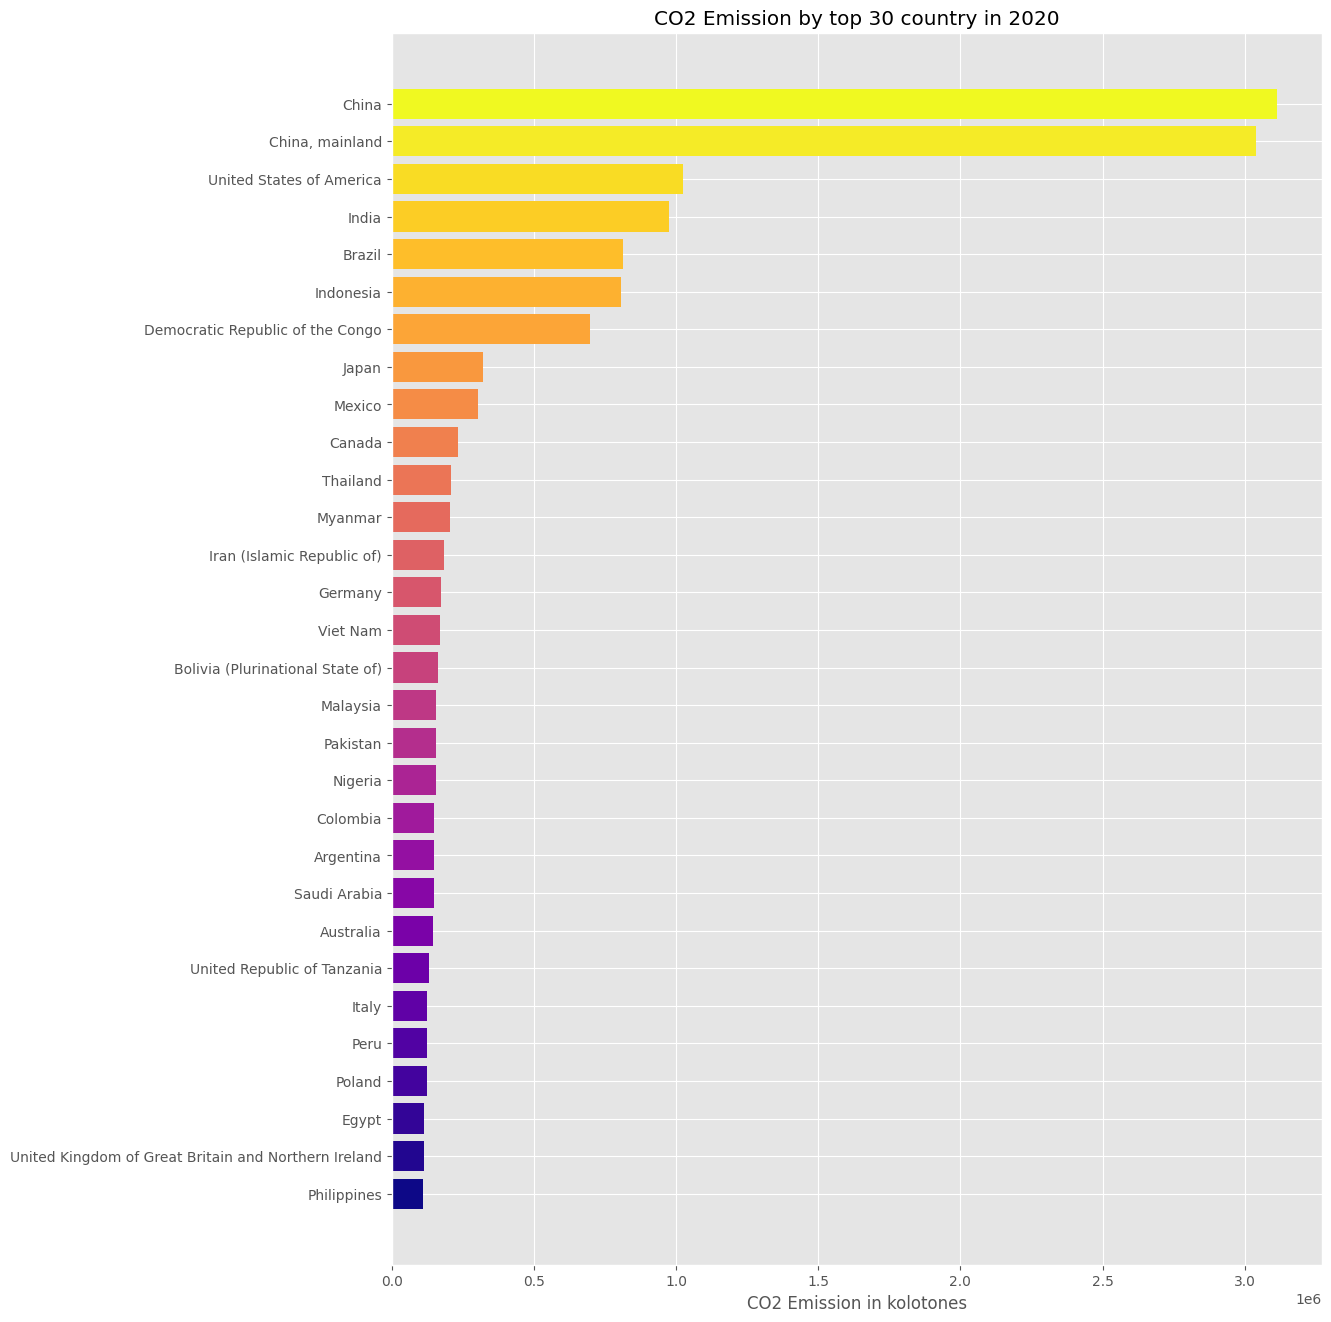

In [6]:
def country_emission(df,year, length = 30):
        df = df.copy()
        plot = df.loc[df["Year"]==year]
        plot = plot.sort_values(by = "total_emission", ascending = True).tail(length)
        colors = plt.cm.get_cmap('plasma', len(plot))
        plt.figure(figsize=(12, 16))
        plt.barh(plot['Area'], 
                plot['total_emission'], 
                color=colors(range(len(plot))))
        plt.title(f'CO2 Emission by top {length} country in {year}')
        plt.xlabel('CO2 Emission in kolotones')

        plt.show()

country_emission(df, year=2020)

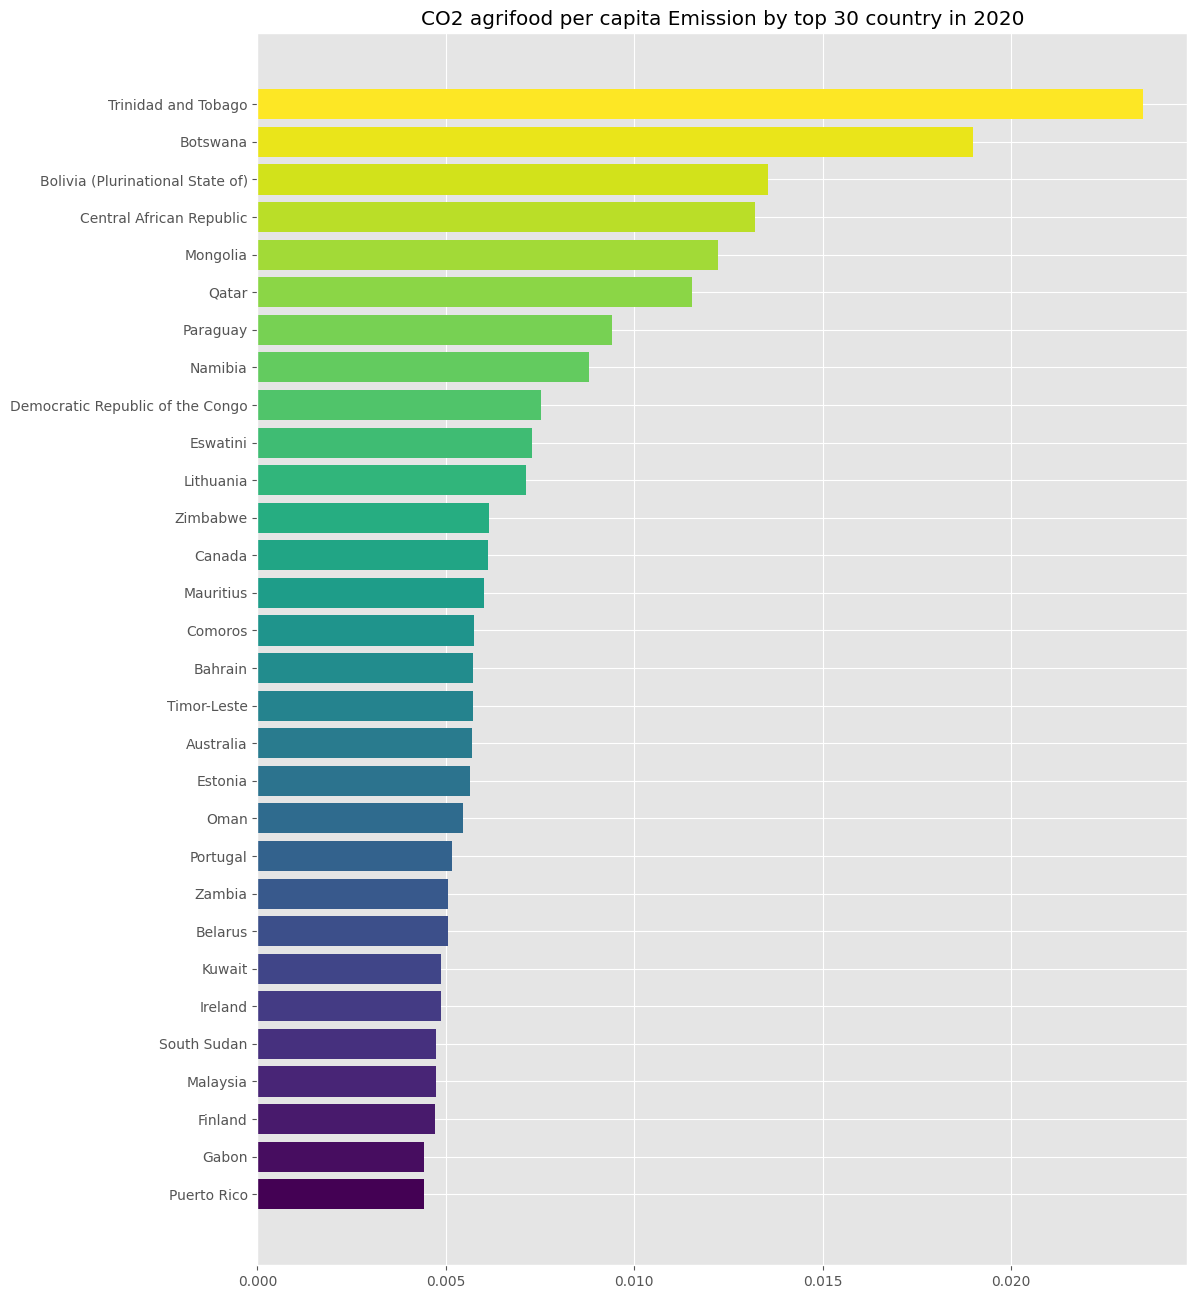

In [7]:
df["pop_tot"] = df["Total Population - Male"] + df["Total Population - Female"]
df["per_capita_emission_kt"] = df["total_emission"] / df["pop_tot"] 

def percapita_emission(df,year, length = 30):
        df = df.copy()
        # let's remove small island or counties ehit this filter
        plot = df.loc[(df["Year"]==year) & (df["pop_tot"] > 800000)]
        plot = plot.sort_values(by = "per_capita_emission_kt", ascending = True).tail(length)
        colors = plt.cm.get_cmap('viridis', len(plot))
        plt.figure(figsize=(12, 16))
        plt.barh(plot['Area'], 
                plot['per_capita_emission_kt'], 
                color=colors(range(len(plot))))
        plt.title(f'CO2 agrifood per capita Emission by top {length} country in {year}')
        plt.show()

percapita_emission(df, year=2020, length=30)

C:\Users\Ananya\AppData\Local\Temp\ipykernel_14800\2224811895.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(axis.get_xticklabels(), rotation='vertical')


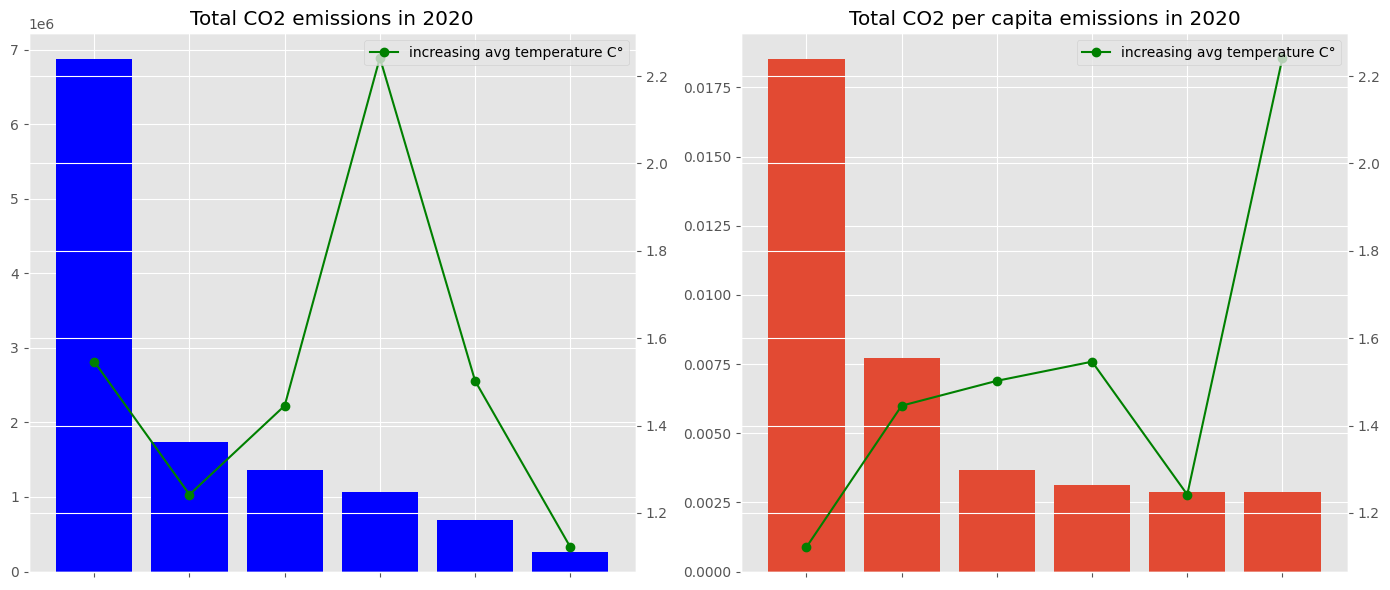

In [8]:
def continental_emission(year =2020):
    continent_df = df.loc[(df.pop_tot > 500000) & (df.Year == year)]\
        .groupby("continent")\
        .agg({"total_emission":"sum",
            "Average Temperature °C":"median",
            "per_capita_emission_kt":"mean"}).reset_index()
    continent_df = continent_df.sort_values(by="total_emission", ascending=False)
    colors = plt.cm.get_cmap('viridis', len(continent_df))

    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    ax[0].bar(continent_df["continent"], continent_df.total_emission, color="blue")
    ax[0].set_title(f"Total CO2 emissions in {year}")

    ax2 = ax[0].twinx() 
    ax2.plot(continent_df["continent"], continent_df["Average Temperature °C"], color='green', marker='o')
    ax2.legend(["increasing avg temperature C°"], loc='upper right') 


    continent_df = continent_df.sort_values(by="per_capita_emission_kt", ascending=False)
    ax[1].bar(continent_df["continent"], continent_df["per_capita_emission_kt"])
    ax[1].set_title(f"Total CO2 per capita emissions in {year}")
    ax3 = ax[1].twinx() 
    ax3.plot(continent_df["continent"], continent_df["Average Temperature °C"], color='green', marker='o')
    ax3.legend(["increasing avg temperature C°"], loc='upper right')

    for axis in ax:
        axis.set_xticklabels(axis.get_xticklabels(), rotation='vertical')

    plt.tight_layout()
    plt.show()

continental_emission(year =2020)

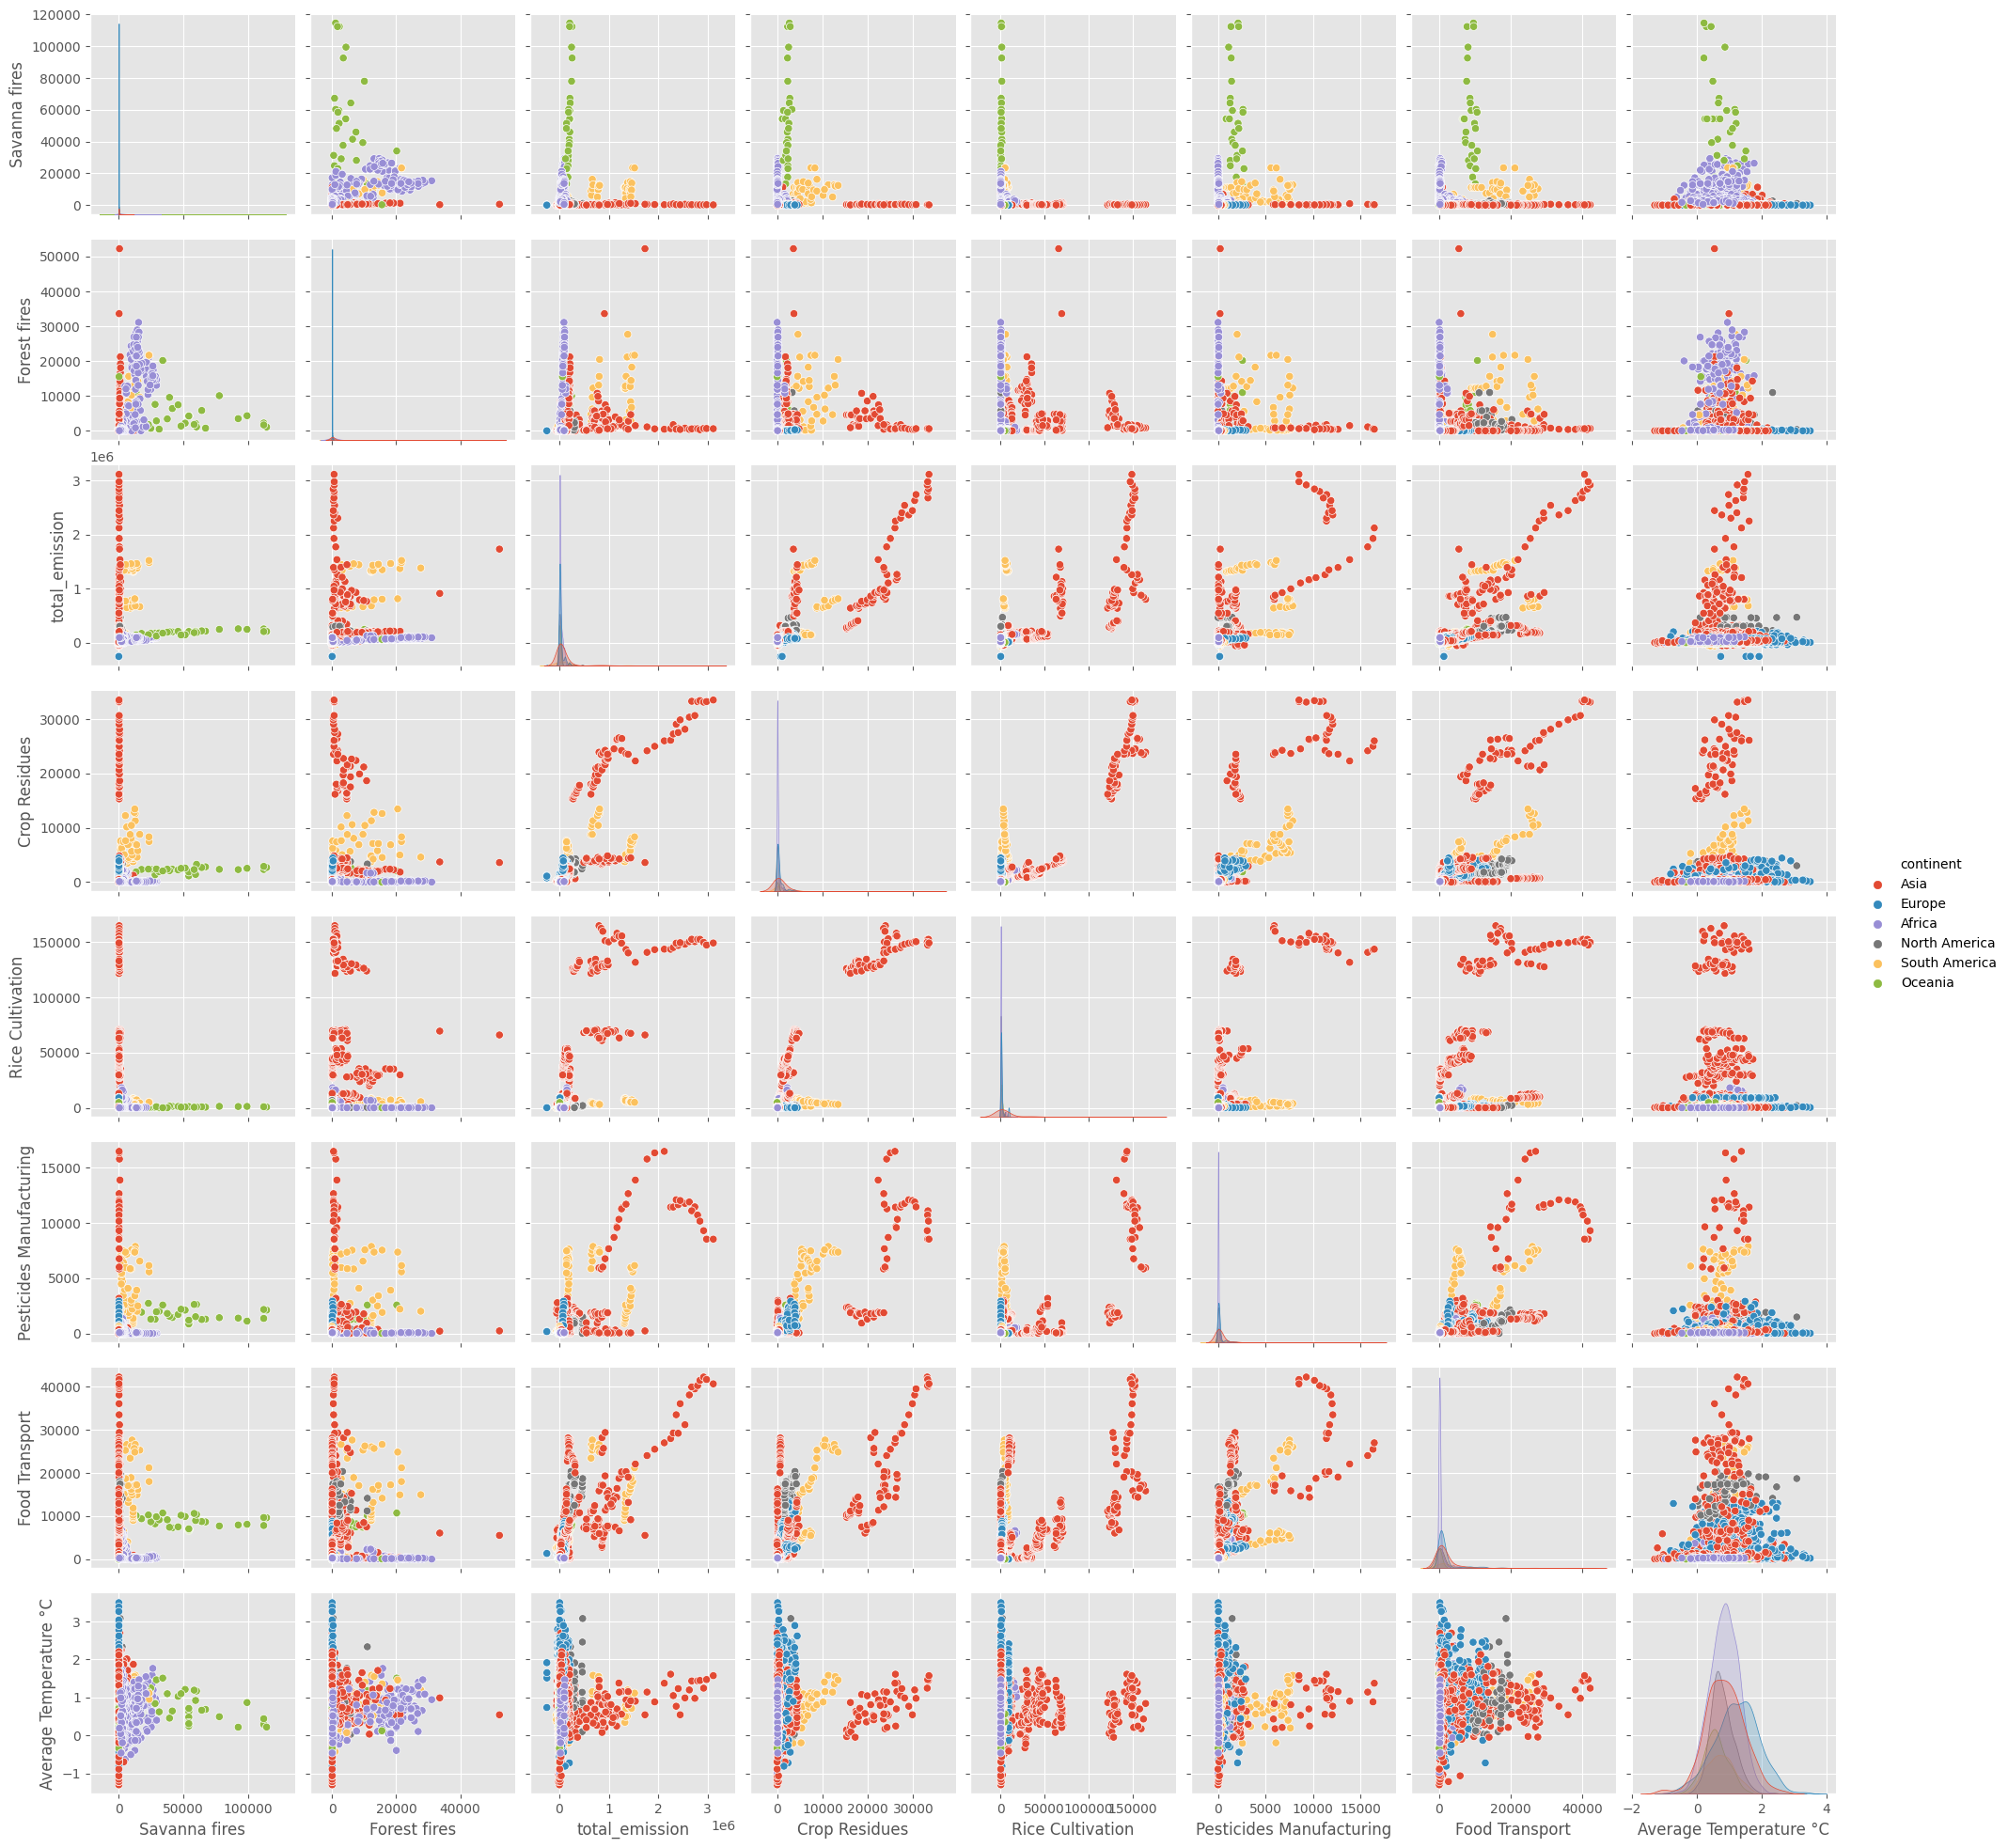

In [9]:
# some relation between vars (samples) and target (avg temperature)

sns.pairplot(df, vars =[
     'Savanna fires', 'Forest fires', 
     "total_emission", 'Crop Residues',
     'Rice Cultivation','Pesticides Manufacturing',
     'Food Transport',"Average Temperature °C"
],
y_vars="Average Temperature °C",
hue = "continent")
plt.show()

In [10]:
# Preprocessing data values
# Replacing missing values with regression tecniques

from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
df.isna().sum()


Area                                  0
Year                                  0
Savanna fires                        31
Forest fires                         93
Crop Residues                      1389
Rice Cultivation                      0
Drained organic soils (CO2)           0
Pesticides Manufacturing              0
Food Transport                        0
Forestland                          493
Net Forest conversion               493
Food Household Consumption          473
Food Retail                           0
On-farm Electricity Use               0
Food Packaging                        0
Agrifood Systems Waste Disposal       0
Food Processing                       0
Fertilizers Manufacturing             0
IPPU                                743
Manure applied to Soils             928
Manure left on Pasture                0
Manure Management                   928
Fires in organic soils                0
Fires in humid tropical forests     155
On-farm energy use                  956


In [11]:
def regressor_imputer(df, feature, max_depth = 6):
    """ This function replace missing values with
        RanfomForestRegressor forecasting """

    df_filled = df.copy()

    if df_filled[feature].isna().any():
        missing_data = df_filled[df_filled[feature].isna()]
        non_missing_data = df_filled.dropna(subset=[feature])

        X_train = non_missing_data.drop(columns=[feature])
        y_train = non_missing_data[feature]

        imputer = SimpleImputer()
        X_train_imputed = imputer.fit_transform(X_train)
        X_missing = missing_data.drop(columns=[feature])
        X_missing_imputed = imputer.transform(X_missing)

        rf = RandomForestRegressor(max_depth = max_depth)
        rf.fit(X_train_imputed, y_train)

        y_missing_pred = rf.predict(X_missing_imputed)

        df_filled.loc[df_filled[feature].isna(), feature] = y_missing_pred

    return df_filled

In [12]:
num_features = [col for col in df.columns if df[col].dtypes in ["int64", "float64"]]
cat_features = [col for col in df.columns if df[col].dtypes in ["object"]]
# let's create a list with onli missing values feature and the replace them with regression 
missing_values = df[num_features].isna().sum()
missing_list=missing_values[missing_values > 0].keys().tolist()


In [13]:
numeric_only = df[num_features ]
def replace_missing(df, missing_list):
    numeric_df = df.copy()
    for feature in tqdm(missing_list):
        numeric_df = regressor_imputer(numeric_df, feature)
    return numeric_df

num_df = replace_missing(numeric_only, missing_list)

  0%|          | 0/11 [00:00<?, ?it/s]

In [14]:
cat_df = df[cat_features].copy() 

label_encoder = LabelEncoder()
for column in cat_df.columns:
    cat_df.loc[:, column] = label_encoder.fit_transform(cat_df[column])

final_df = pd.concat([cat_df,num_df], axis =1)
X = final_df.drop(columns =["Average Temperature °C","per_capita_emission_kt"])
y =final_df["Average Temperature °C"]

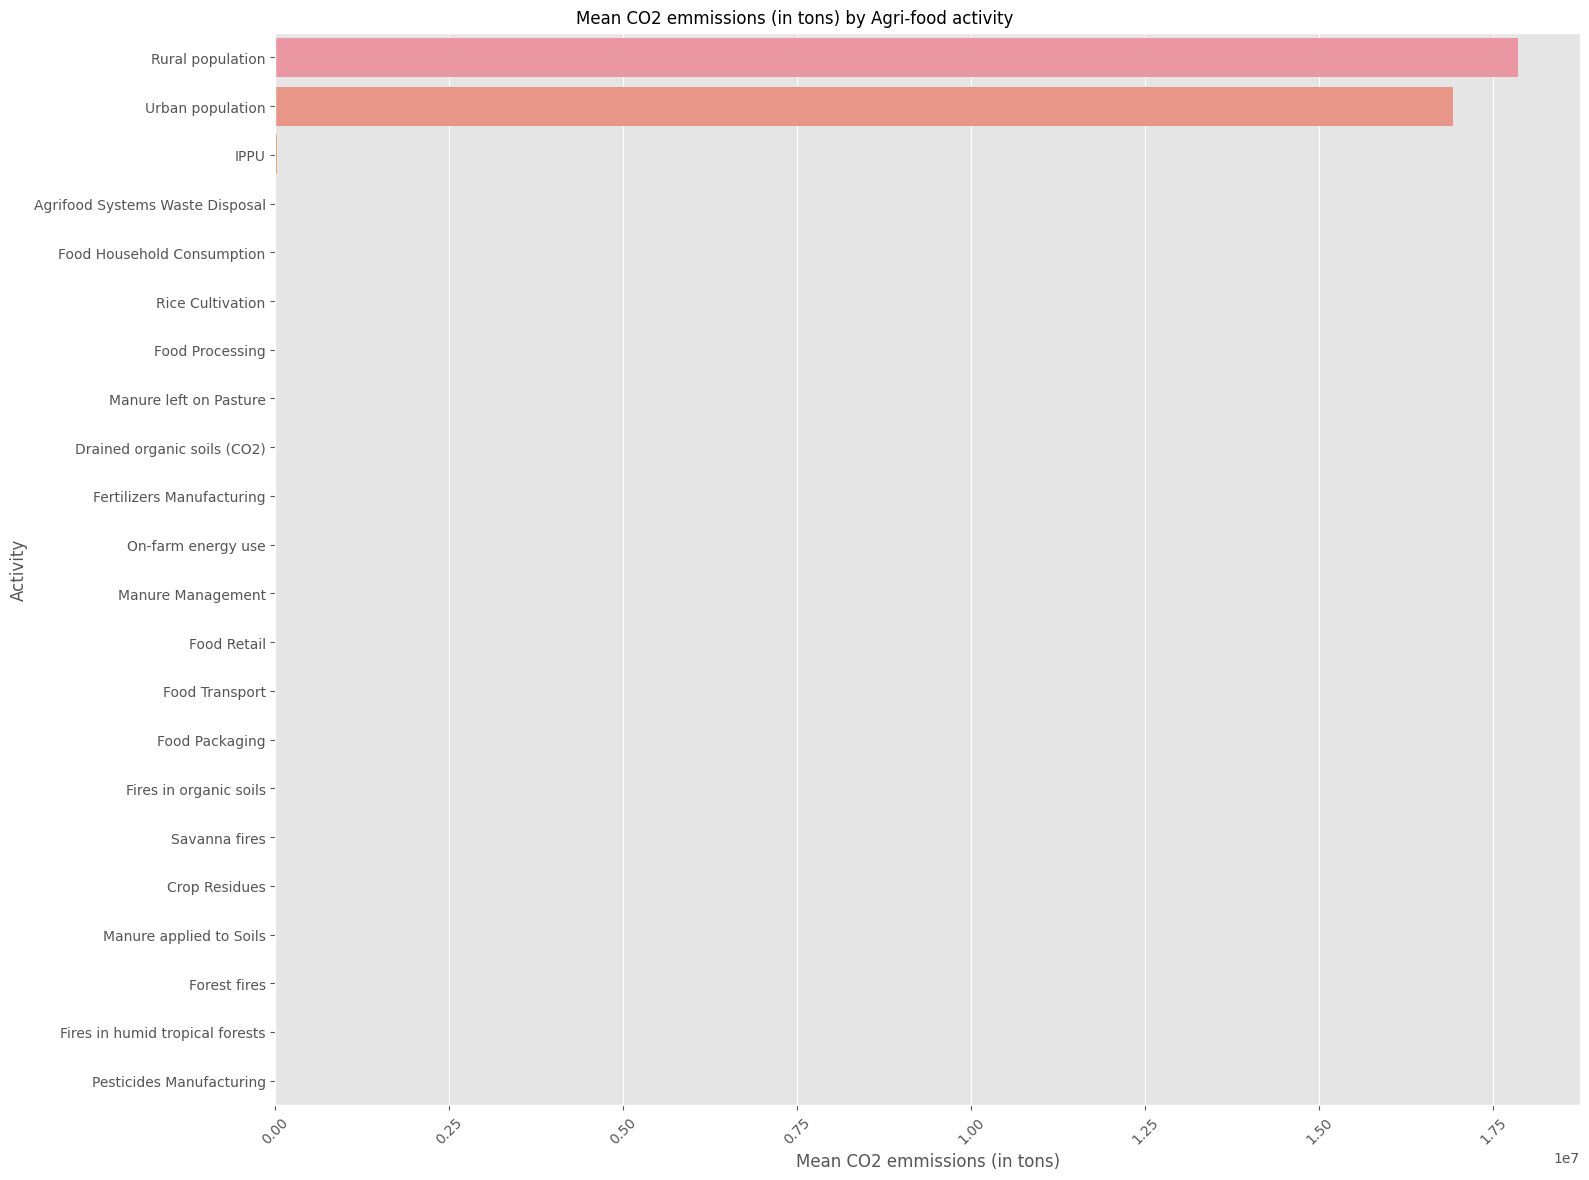

In [15]:
# Now let's see which activity produces the highest CO2 emissions.
temp = df.iloc[:, 2: -7].copy() # Do not include the first and second column as it is area and year
delete_list = ['Forestland', 'Net Forest conversion', 'On-farm Electricity Use'] #rule out all non-relevant features
temp = temp.drop(delete_list, axis = 1)
means = temp.mean()#calculate the mean anual values for each feature
means.sort_values(ascending = False, inplace = True) #sort them in descending order
cols = means.index #the column names are the indices
fig, ax = plt.subplots(figsize=(16, 12))
sns.barplot(x=means, y=cols, ax=ax) #wrap x and y parameters

ax.set_ylabel("Activity")  # Set the y-axis label
ax.set_xlabel("Mean CO2 emmissions (in tons)")     # Set the x-axis label
fig.suptitle('Mean CO2 emmissions (in tons) by Agri-food activity')

plt.xticks(rotation=45)      # Rotate x-axis labels for better visibility
plt.tight_layout()           # Adjust layout to prevent labels from getting cut off
plt.show()

In [16]:
# Select relevant columns
selected_columns = ['Area', 'total_emission', 'Agrifood Systems Waste Disposal', 'Food Household Consumption',
                    'Forest fires', 'Fires in humid tropical forests', 'Savanna fires',
                    'IPPU', 'Food Processing', 'Food Transport', 'Food Packaging', 'Pesticides Manufacturing',
                    'Fertilizers Manufacturing', 'Food Retail',
                    'Rice Cultivation', 'Manure left on Pasture', 'Drained organic soils (CO2)',
                    'Crop Residues', 'Manure Management', 'Manure applied to Soils', 'Average Temperature °C', 'Year']

# Create a simplified DataFrame with selected columns
temp2 = df[selected_columns].copy()

# Calculate the categories total values
emission_sources = ['Forest fires', 'Fires in humid tropical forests', 'Savanna fires',
                    'IPPU', 'Food Processing', 'Food Transport', 'Food Packaging', 'Pesticides Manufacturing',
                    'Fertilizers Manufacturing', 'Food Retail',
                    'Rice Cultivation', 'Manure left on Pasture', 'Drained organic soils (CO2)',
                    'Crop Residues', 'Manure Management', 'Manure applied to Soils']

temp2['total_fire_emissions'] = temp2[emission_sources[:3]].sum(axis=1)
temp2['total_industrial_emissions'] = temp2[emission_sources[3:12]].sum(axis=1)
temp2['total_cultivation_emissions'] = temp2[emission_sources[12:]].sum(axis=1)


# Calculate mean values for all emission sources
means = temp2[['total_fire_emissions', 'total_industrial_emissions', 'total_cultivation_emissions',
               'Agrifood Systems Waste Disposal', 'Food Household Consumption']].mean()
means.rename({'total_fire_emissions' : 'mean_fire_emissions', 'total_industrial_emissions' : 'mean_industrial_emissions', 
                       'total_cultivation_emissions' : 'mean_cultivation_emissions', 
                       'Agrifood Systems Waste Disposal' :  'mean Agrifood Systems Waste Disposal', 
                       'Food Household Consumption' : 'mean Food Household Consumption'})


# Sort columns based on mean values in descending order
means.sort_values(ascending=False, inplace = True)

cols = means.index

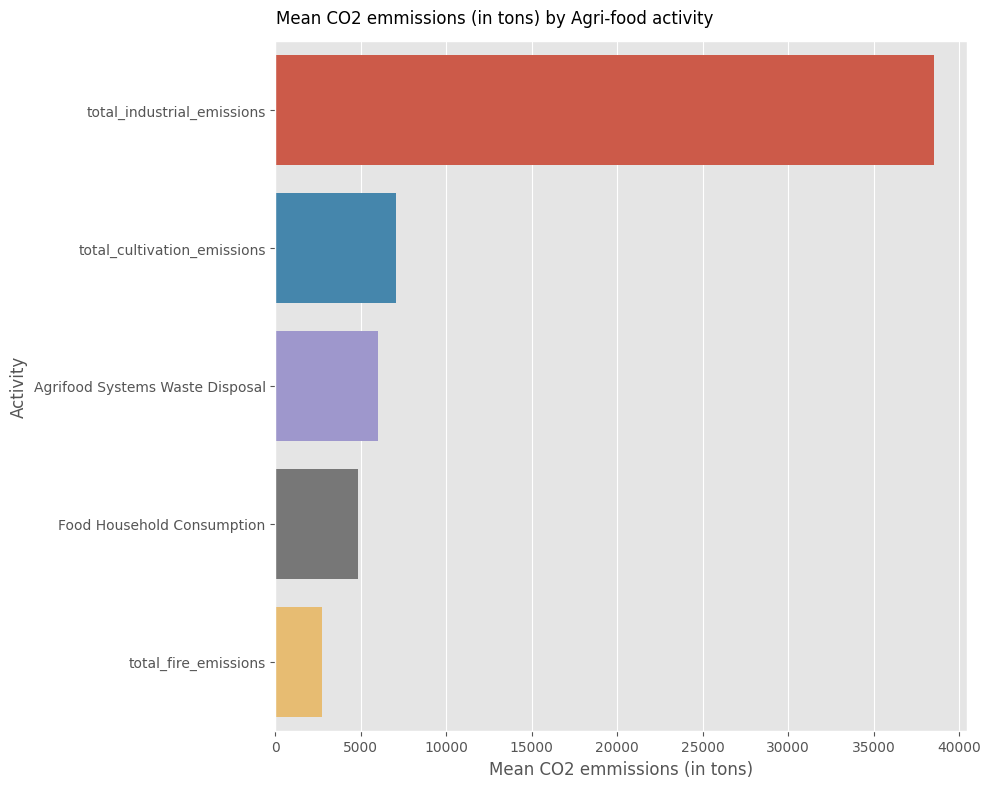

In [17]:
fig, ax = plt.subplots(figsize=(10, 8)) 
sns.barplot(x=means, y=cols, ax=ax) #wrap x and y parameters

ax.set_ylabel("Activity")  # Set the y-axis label
ax.set_xlabel("Mean CO2 emmissions (in tons)")     # Set the x-axis label
fig.suptitle('Mean CO2 emmissions (in tons) by Agri-food activity')
      
plt.tight_layout()           # Adjust layout to prevent labels from getting cut off
plt.show() #